<a href="https://colab.research.google.com/github/CardosoJr/bootcamp/blob/main/Labs/Lab%209%20-%20ML%20pt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - ML - parte 2

Neste lab, vamos aprofundar em classificadores e entender:
* Outputs de classificação e thresholds
* Métricas de avaliação de classificadores
* Feature Engineering + Feature Selection
* Hypeparameter Tuning

## No Free Lunch Theorem
"No machine learning algorithm is universally any better than any other"

## Classificação Binária: Probabilidades

Relembrando um problema de classificação binária e um modelo linear com pesos $\mathbf{w}$ que cria a superfície (nesse caso um hiperplano / reta) que separa as duas classes.


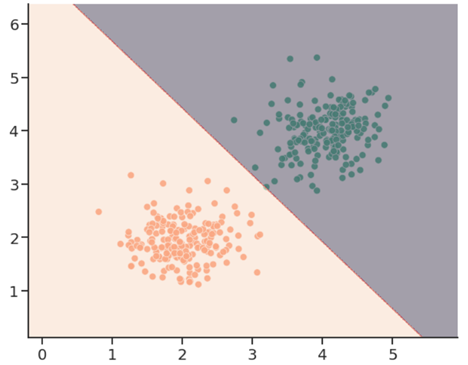

Em muitos casos, não queremos apenas uma resposta binária, mas a probabilidade da amostra de fazer parte de uma classe ou não, ou seja
$$ P(Y = c_1 | \mathbf{x})$$

Assim, grande partes dos classificadores naturalmente têm como resposta probabilidades. Vamos entender um pouco mais sobre isso abaixo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks', palette='Set2')
sns.set_context("talk", font_scale=1.2)
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#### Tratando os dados

In [2]:
!pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("telco_churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
import category_encoders as ce

In [7]:
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [6]:
df['Churn'] = df['Churn'].map({"No" : 0, "Yes" : 1})

In [8]:
one_hot_cols = []
binary_cols = []

for col in category_cols:
  if df[col].nunique() > 2:
    one_hot_cols.append(col)
  else:
    binary_cols.append(col)

In [9]:
df.drop(columns = ['customerID'], inplace = True)

In [10]:
df = ce.OneHotEncoder(cols = one_hot_cols).fit_transform(df)

In [11]:
df = ce.OrdinalEncoder(cols = binary_cols).fit_transform(df)

In [12]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,...,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges,Churn
0,1,1,1,1,1,1,1,0,0,1,...,0,0,1,1,0,0,0,29.85,29.85,0
1,2,1,2,1,34,2,0,1,0,1,...,1,0,2,0,1,0,0,56.95,1889.50,0
2,2,1,2,1,2,2,0,1,0,1,...,0,0,1,0,1,0,0,53.85,108.15,1
3,2,1,2,1,45,1,1,0,0,1,...,1,0,2,0,0,1,0,42.30,1840.75,0
4,1,1,2,1,2,2,0,1,0,0,...,0,0,1,1,0,0,0,70.70,151.65,1


In [13]:
df.dropna(inplace = True)

In [14]:
TARGET = 'Churn'
FEATURES = [x for x in df.columns if x != TARGET]

Algo comum a datasets de churn é que deve ser desbalanceado, ou seja, temos quantidades bem diferente de amostras entre as duas classes. Vamos confirmar se este é o caso

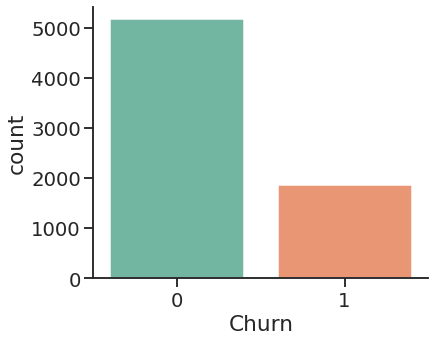

In [ ]:
fig, ax = plt.subplots(figsize = (6,5))
sns.countplot('Churn', data = df, ax = ax)
sns.despine()

In [ ]:
1 - df['Churn'].mean()

0.7342150170648465

### Um exemplo: regressão logística
Relembrando que em um modelo linear, a superfície de separação é dada por:

$$\mathbf{w}^T\mathbf{x} + \alpha = 0$$

No caso da regressão logística, vamos aplicar a função logística (ou sigmoid):

$$\mathbf{Z} = \mathbf{w}^T\mathbf{x} + \alpha$$
$$ \sigma(Z) = \frac{1}{1 + e^{-Z}} $$


Resumindo, temos (faltou o termo de bias na visualização abaixo):

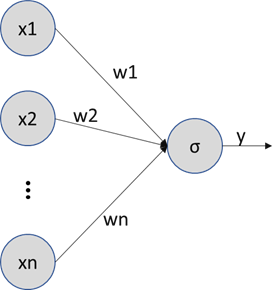

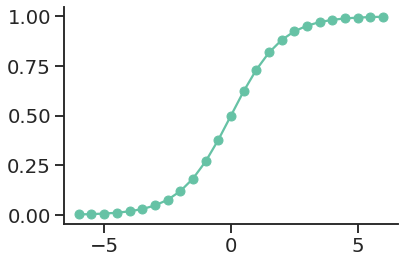

In [ ]:
from scipy.special import expit
x = np.linspace(-6,6,25)
y = expit(x)

plt.plot(x, y, 'o-')
sns.despine()

Podemos interpretar $\sigma(Z)$ como probabilidades

**Treinando uma regressão logística**

Uma regressão logística é definida pelo conjunto de pesos $\mathbf{w}$

No final das contas, queremos entender: $$ P(Y | X, \mathbf{w}) $$,

vamos lembrar que pelo teorema de bayes

$$ P(Y|X) = \frac{P(X|Y) \, P(Y)}{P(X)} $$


Chamamos de $P(X|Y, \mathbf{w})$ de verossimilhança ou liklelihood, portanto o método Maximum Likelihood Estimation é utilizado para maximizar esta probabilidade e encontrar os melhores valores de $\mathbf{w}$

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

X = df[FEATURES]
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, df[TARGET], test_size = 0.3, random_state = 42)

X_train = scaler.fit_transform(X = X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

In [ ]:
indexes = np.argsort(np.squeeze(model.coef_))
coef = np.squeeze(model.coef_)[indexes]


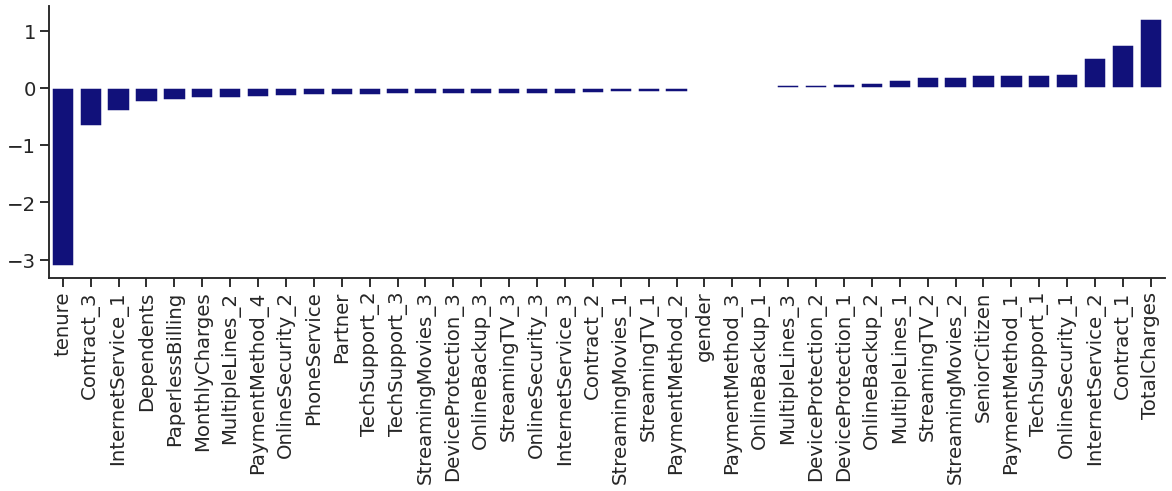

In [ ]:
fig, ax = plt.subplots(figsize = (20,5))
sns.barplot(np.array(FEATURES)[indexes], coef, ax = ax, color = 'darkblue')
plt.xticks(rotation = 90)
sns.despine()

## Métricas

**Acurácia**

$$ \frac{\text{# Acertos}}{\text{# Amostras}}$$

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.795734597156398

**Matriz de Confusão**

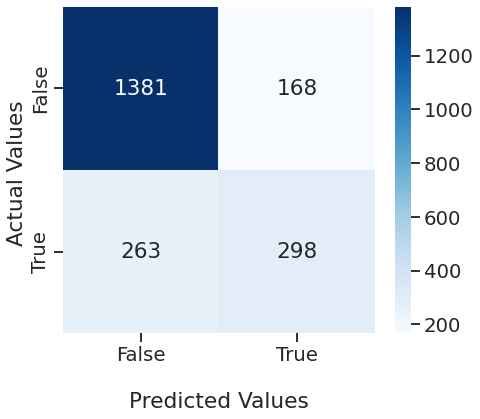

In [ ]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(cm,annot=True, cmap='Blues', fmt=".0f")
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True']);

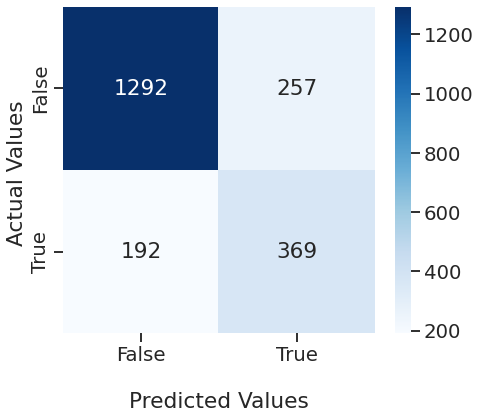

In [ ]:
cm = confusion_matrix(y_test, (y_prob > 0.4))

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(cm,annot=True, cmap='Blues', fmt=".0f")
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True']);

**Curva ROC e AUC**

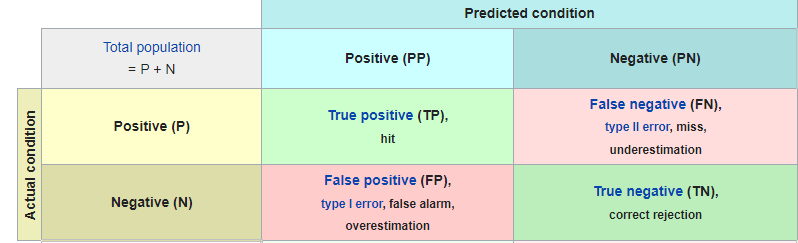


* True Positive Rate: $\frac{TP}{P}$
* False Positive Rate: $\frac{FP}{N}$

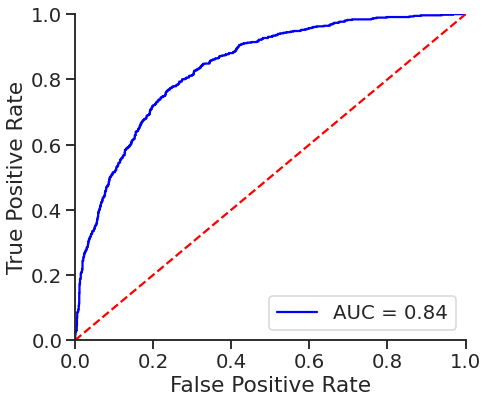

In [ ]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize = (7,6))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
sns.despine()


**Precision x Recall**

Recall já vimos, é True Positive Rate. Agora Precision é $\frac{TP}{TP + FP}$

In [ ]:
metrics.precision_score(y_test, y_pred)

0.6394849785407726

In [ ]:
metrics.recall_score(y_test, y_pred)

0.5311942959001783

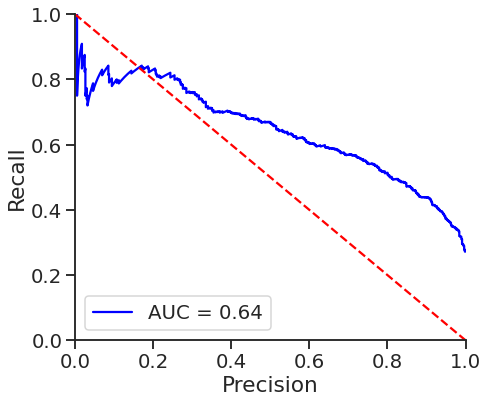

In [ ]:
precision, recall, ts_pr  = metrics.precision_recall_curve(y_test, y_prob)
roc_auc = metrics.auc(recall, precision)

fig, ax = plt.subplots(figsize = (7,6))
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower left')
plt.plot([0, 1], [1, 0],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
sns.despine()

## Threshold

Para cada aplicação, devemos balizar os custos dos TP e TN e também dos FP e FN. Para isso, podemos calcular o risco associado ao classificador para cada threshold

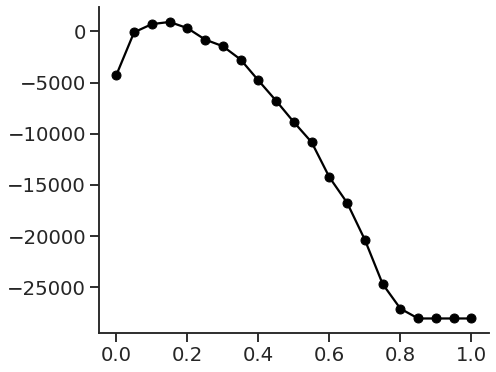

In [ ]:
risk = []
thresholds = np.linspace(0,1,21)

for p in thresholds:
  cm = confusion_matrix(y_test, (y_prob > p))
  risk.append(cm[0,0] * 0 + cm[1,1] * 20 + cm[0,1] * (-10) + cm[1,0] * (-50))

fig, ax = plt.subplots(figsize = (7,6))

plt.plot(thresholds, risk, 'o-k',)
sns.despine()

## Teste de Modelos

### Treino / Teste

* Já falamos da importância de separar os dados entre treino e teste


### Cross-validation

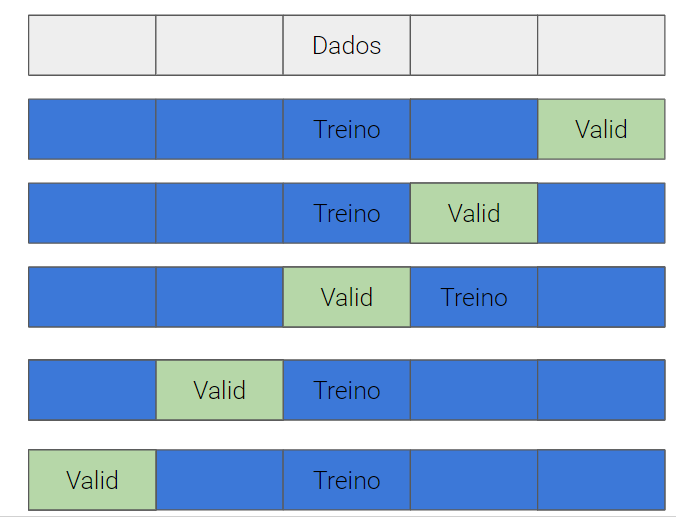

In [ ]:
from sklearn.model_selection import cross_validate

cv_score = cross_validate(model, X, df[TARGET], cv = 5, scoring = 'accuracy')

In [ ]:
np.mean(cv_score['test_score'])

0.8034669165855342

In [ ]:
np.std(cv_score['test_score'])

0.013486895854182283

## Feature Engineering & Feature Selection

In [ ]:
df.corr().style.background_gradient(cmap = 'coolwarm').set_precision(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,InternetService_2,InternetService_3,OnlineSecurity_1,OnlineSecurity_2,OnlineSecurity_3,OnlineBackup_1,OnlineBackup_2,OnlineBackup_3,DeviceProtection_1,DeviceProtection_2,DeviceProtection_3,TechSupport_1,TechSupport_2,TechSupport_3,StreamingTV_1,StreamingTV_2,StreamingTV_3,StreamingMovies_1,StreamingMovies_2,StreamingMovies_3,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges,Churn
gender,1.00,-0.00,0.00,0.01,0.01,-0.01,0.01,0.00,-0.01,0.01,-0.01,0.00,0.01,-0.02,0.00,-0.01,0.01,0.00,-0.00,-0.00,0.00,0.00,-0.01,0.00,0.00,-0.01,0.00,0.01,-0.01,0.00,-0.00,0.01,-0.00,0.01,0.00,0.01,-0.02,0.00,-0.01,0.00,-0.01
SeniorCitizen,-0.00,1.00,-0.02,-0.21,0.02,0.01,-0.01,-0.14,0.14,-0.11,0.25,-0.18,0.19,-0.04,-0.18,0.07,0.09,-0.18,0.09,0.06,-0.18,0.21,-0.06,-0.18,0.05,0.11,-0.18,0.03,0.12,-0.18,0.14,-0.05,-0.12,-0.16,0.17,-0.15,-0.02,-0.02,0.22,0.10,0.15
Partner,0.00,-0.02,1.00,-0.45,-0.38,-0.02,0.02,0.13,-0.14,0.00,-0.00,0.00,0.13,-0.14,0.00,-0.14,0.14,0.00,0.15,-0.15,0.00,0.11,-0.12,0.00,0.12,-0.12,0.00,0.12,-0.12,0.00,0.28,-0.08,-0.25,-0.01,0.08,0.10,-0.11,-0.08,-0.10,-0.32,0.15
Dependents,0.01,-0.21,-0.45,1.00,0.16,-0.00,0.00,0.02,-0.02,0.05,-0.16,0.14,-0.19,0.08,0.14,0.02,-0.14,0.14,-0.13,0.01,0.14,-0.17,0.06,0.14,-0.10,-0.02,0.14,-0.08,-0.04,0.14,-0.23,0.07,0.20,0.11,-0.15,0.06,0.05,0.06,-0.11,0.06,-0.16
tenure,0.01,0.02,-0.38,0.16,1.00,0.01,-0.01,-0.32,0.33,0.01,0.02,-0.04,-0.27,0.33,-0.04,0.36,-0.31,-0.04,-0.31,0.36,-0.04,-0.26,0.33,-0.04,-0.25,0.28,-0.04,-0.25,0.29,-0.04,-0.65,0.20,0.56,-0.00,-0.21,-0.23,0.24,0.23,0.25,0.83,-0.35
PhoneService,-0.01,0.01,-0.02,-0.00,0.01,1.00,-1.00,0.32,0.28,-0.45,0.29,0.17,-0.06,-0.09,0.17,-0.05,-0.09,0.17,-0.08,-0.07,0.17,-0.06,-0.10,0.17,-0.12,-0.02,0.17,-0.11,-0.03,0.17,-0.00,-0.00,0.00,-0.02,0.00,-0.00,0.01,-0.01,0.25,0.11,0.01
MultipleLines_1,0.01,-0.01,0.02,0.00,-0.01,-1.00,1.00,-0.32,-0.28,0.45,-0.29,-0.17,0.06,0.09,-0.17,0.05,0.09,-0.17,0.08,0.07,-0.17,0.06,0.10,-0.17,0.12,0.02,-0.17,0.11,0.03,-0.17,0.00,0.00,-0.00,0.02,-0.00,0.00,-0.01,0.01,-0.25,-0.11,-0.01
MultipleLines_2,0.00,-0.14,0.13,0.02,-0.32,0.32,-0.32,1.00,-0.82,-0.07,-0.19,0.31,-0.12,-0.15,0.31,-0.23,-0.04,0.31,-0.03,-0.24,0.31,-0.11,-0.16,0.31,0.01,-0.27,0.31,0.01,-0.28,0.31,0.09,0.00,-0.10,0.15,-0.08,0.22,-0.07,-0.06,-0.34,-0.40,-0.03
MultipleLines_3,-0.01,0.14,-0.14,-0.02,0.33,0.28,-0.28,-0.82,1.00,-0.20,0.37,-0.21,0.08,0.10,-0.21,0.20,-0.02,-0.21,-0.02,0.20,-0.21,0.08,0.10,-0.21,-0.08,0.26,-0.21,-0.08,0.26,-0.21,-0.09,-0.00,0.11,-0.16,0.08,-0.23,0.08,0.06,0.49,0.47,0.04
InternetService_1,0.01,-0.11,0.00,0.05,0.01,-0.45,0.45,-0.07,-0.20,1.00,-0.64,-0.38,0.02,0.32,-0.38,0.16,0.16,-0.38,0.18,0.15,-0.38,0.03,0.31,-0.38,0.30,0.01,-0.38,0.29,0.03,-0.38,-0.07,0.05,0.03,0.06,-0.10,0.04,0.02,0.05,-0.16,-0.05,-0.12


In [ ]:
import xgboost
model = xgboost.XGBClassifier(n_estimators = 200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
score

0.7990521327014218

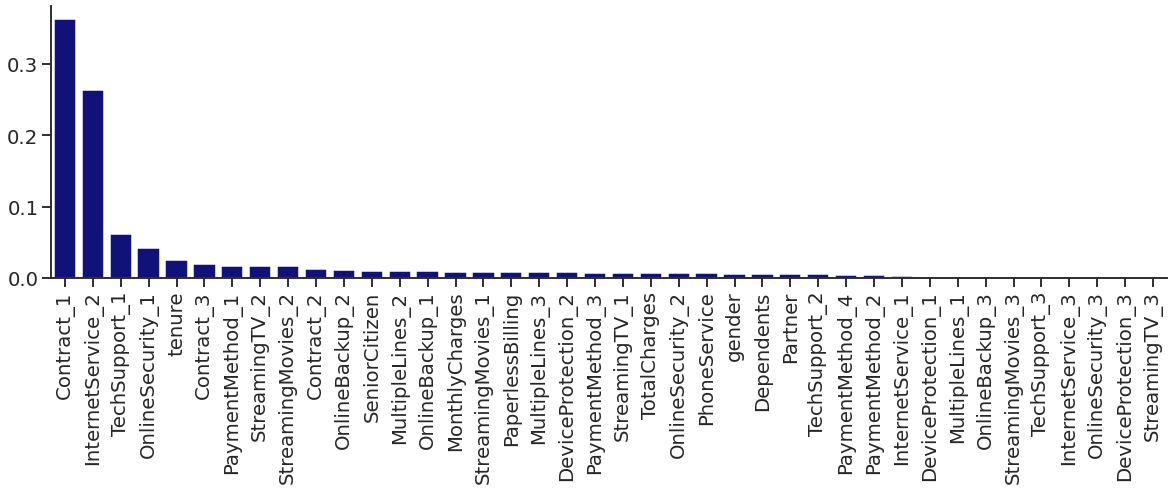

In [ ]:
indexes = np.argsort(model.feature_importances_)[::-1]
coef = model.feature_importances_[indexes]

fig, ax = plt.subplots(figsize = (20,5))
sns.barplot(np.array(FEATURES)[indexes], coef, ax = ax, color = 'darkblue')
plt.xticks(rotation = 90)
sns.despine()

## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

#### Xgboost

In [ ]:
import xgboost

In [ ]:
model = xgboost.XGBClassifier()

parameters = {'scale_pos_weight' : [1, 5],
              'n_estimators' : [50, 1000],
              'learning_rate' : [0.01, 0.05]}

gs = GridSearchCV(model, param_grid = parameters, cv = 5, scoring = 'accuracy', return_train_score = True, n_jobs = -1, verbose=10)
gs_score = gs.fit(X, df[TARGET])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
def get_params(gs_results):
    param_names = gs_results['params'][0].keys()

    param_values = {}
    for p in param_names:
        param_values[p] = []

    for r in gs_results['params']:
        for p in param_names:
            param_values[p].append(r[p])

    return param_values

def process_gs_results(gs_results, params, cv = 5):
    test_scores = []
    train_scores = []
    for k in range(cv):
        test_scores.extend(gs_results[f'split{k}_test_score'])
        train_scores.extend(gs_results[f'split{k}_train_score'])
    if params is not None:
        params = [str(x) for x in params]
        result = pd.DataFrame({'Param' : params * cv * 2, 'Score' : train_scores + test_scores, 'Train / Test' : ['train'] * len(train_scores) + ['test'] * len(test_scores)})
    else:
        param_values = get_params(gs_results)
        for k in param_values.keys():
            param_values[k] = param_values[k] * 2 * cv
        result = pd.DataFrame(dict(param_values, **{'Score' : train_scores + test_scores, 'Train / Test' : ['train'] * len(train_scores) + ['test'] * len(test_scores)}))

    result.columns = [x.replace("model__", "") for x in result.columns]
    # result = pd.DataFrame({'Param' : params * cv , 'Train_Score' : train_scores, 'Test_Score' : test_scores })
    return result

In [ ]:
result = process_gs_results(gs.cv_results_, params = None, cv = 5)

In [ ]:
result[result['Train / Test'] == 'test'].sort_values(by = 'Score', ascending = False).head(10)

,learning_rate,n_estimators,scale_pos_weight,Score,Train / Test
42,0.01,1000,1,0.817342,test
44,0.05,50,1,0.813788,test
66,0.01,1000,1,0.809388,test
50,0.01,1000,1,0.808102,test
54,0.05,1000,1,0.805259,test
40,0.01,50,1,0.803838,test
52,0.05,50,1,0.803838,test
68,0.05,50,1,0.803698,test
70,0.05,1000,1,0.802276,test
76,0.05,50,1,0.799431,test
